## Model Robustness at The Prediction Stage: Estimating Epistemic Uncertainty using Bootstrapping Technique

Estimating epistemic uncertainty plays a crucial role in enhancing the safety of AI-based decision-making in several ways.
   
Here, we try to showcase how to use a bag of GBC classifier to estimate the prediction uncertainty on our adapted Diabetes dataset. 

In [1]:
!pip install scikit-learn --upgrade

### Importing Packages and Data Preparation

In [74]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


# Load the Diabetes dataset
diabetes_data = load_diabetes()
X = diabetes_data.data
y = diabetes_data.target

# Set a threshold for binary classification (e.g., using the median of y)
threshold = np.median(y)
y_binary = (y > threshold).astype(int)  # 1 for high risk, 0 for low risk

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fitting a bag of GBC clasifer and computing model accuracy

In [75]:
# Define the base model
base_model = GradientBoostingClassifier(random_state=42)

# Define the BaggingClassifier with 1000 base models
model = BaggingClassifier(estimator=base_model, n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the BaggingClassifier on the Test Set: {accuracy:.2f}")

Accuracy of the BaggingClassifier on the Test Set: 0.72


### Estimating the epistemic uncertainty
Here we first predict using all the models in the bag on the test set, then calculate the median for the final prediction, and 5-percentile as a lower bound, and 95-percentile as higher bound for the prediction.

In [76]:
# Get the predictions from each base model in the ensemble
predictions = np.array([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_])

# Calculate the 5th and 95th percentiles of the predictions
lower_bound = np.percentile(predictions, 5, axis=0)
upper_bound = np.percentile(predictions, 95, axis=0)
median_predictions = np.median(predictions, axis=0)

### Plotting the prediction with uncertainty estimates:

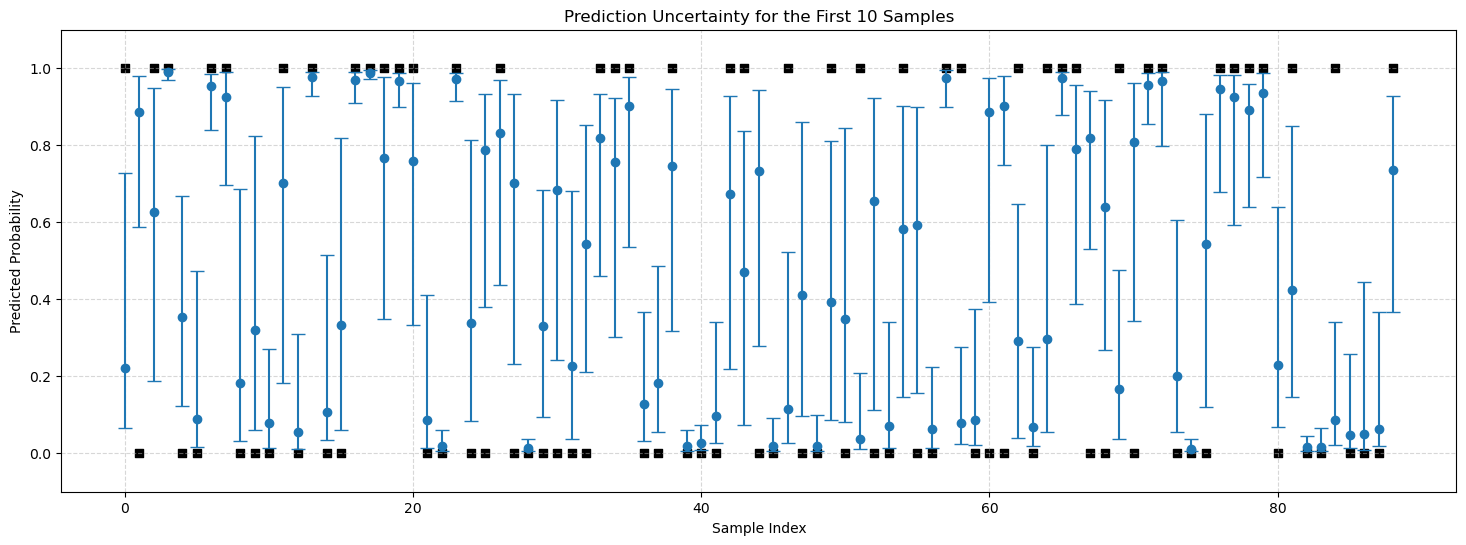

In [77]:
# Plot error bars for predictions
indices = range(median_predictions.shape[0])
plt.figure(figsize=[18,6])
plt.errorbar(indices, median_predictions, yerr=[median_predictions - lower_bound, upper_bound - median_predictions], fmt='o',capsize=5)
plt.scatter(indices, y_test[indices], marker='s', c='k')
plt.title('Prediction Uncertainty for the First 10 Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.ylim(-0.1,1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### More Informed and Safe Decision Making

We can use the estimated prediction uncertainties for more informade decision making. For example, using a threshold on the uncertainty, we can exclude uncertain predictions from decision making process. This will reduce the decisiveness of the model (number of used model predictions for decision making), but increases the accuracy of decisions and trust in the model. This sometimes can be a game changer as it transfers a risky/unsafe and not-usable model in practice to a useful trustworthy/safe model. 

In [78]:
threshold = 0.1
idx = upper_bound - lower_bound < threshold

accuracy = accuracy_score(y_test[idx], y_pred[idx])
decisiveness = sum(idx)/idx.shape[0]

print(f"The model can give us certain decisions about {decisiveness:.2f} of the test samples with the accuracy of: {accuracy:.2f}")



The model can give us certain decisions about 0.18 of the test samples with the accuracy of: 1.00


**Exercise 5.3** Change the treshold in the above example from 0 to 1 and plot (let's say in 0.05 intervals) the decisiveness-accuracy curve (decissivness on the x-axis and accuracy on the y-axis). What would be the best threshold for this example? Discuss. 

In [79]:
accuracy_list = [] 
decisiveness_list = [] 
time_steps = []
for i in range(0,100, 5): 
    try:
        threshold = i / 100 + 0.05
        print(threshold)
    except: 
        print('err')      
        
    idx = upper_bound - lower_bound < threshold  
    accuracy = accuracy_score(y_test[idx], y_pred[idx])
    decisiveness = sum(idx)/idx.shape[0] 

    accuracy_list.append(accuracy) 
    decisiveness_list.append(decisiveness)   
    time_steps.append(i)

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


''

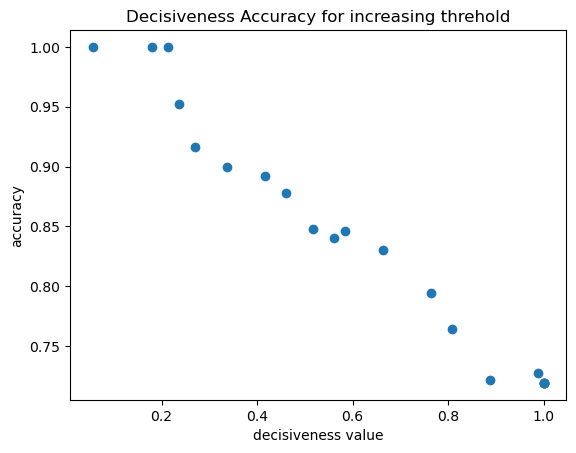

In [84]:
plt.scatter(x=decisiveness_list, y=accuracy_list) 
#plt.scatter(x=time_steps, y=accuracy_list) 
#plt.legend(['decisiveness', 'accuracy']) 
plt.title('Decisiveness Accuracy for increasing threhold')  
plt.xlabel('decisiveness value')  
plt.ylabel('accuracy')
;

# Discussion  
From the prediction uncertainty boxplots of the samples, it appears that prediction probabilities lower than 0.9 carry a lot of uncertainy. With this specific data the accuracy is 0.72. This matches the large likelihood of predictions with probabilities between 0.1 and 0.9 (from the boxplot visualization) spanning above and below 0.5. the best threshold value would be right at the third point of the plot from left to right, for predictions that that have an interval difference higher than that threshold value we see accuracy beging to drop significantly. Scrutinizing the model's decisions fruther would be of interest as misdiagnosis can have consequences for the individuals dealing with the machine learning model. 